In [1]:
# @title Install madrona_mjx and quadruped_mjx_rl

# install additional missing packages
!sudo apt install -y libx11-dev libxrandr-dev libxinerama-dev libxcursor-dev libxi-dev mesa-common-dev
# the following is for kaggle
#!sudo apt install -y nvidia-cuda-toolkit

# install jax with cuda enabled
!pip install -U "jax[cuda12_local]==0.5.2"

# get madrona mjx and its subpackages
!mkdir modules
!git clone https://github.com/shacklettbp/madrona_mjx.git modules/madrona_mjx
!git -C modules/madrona_mjx submodule update --init --recursive

# build madrona mjx
!mkdir modules/madrona_mjx/build
!cd modules/madrona_mjx/build && cmake -DLOAD_VULKAN=OFF .. && make -j 8

# install madrona mjx
!pip install -e modules/madrona_mjx

# Clones and installs our Quadruped RL package
!git clone https://github.com/alexeiplatzer/unitree-go2-mjx-rl.git
!pip install -e unitree-go2-mjx-rl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libx11-dev is already the newest version (2:1.7.5-1ubuntu0.3).
libx11-dev set to manually installed.
The following additional packages will be installed:
  libdrm-dev libgl-dev libglx-dev libpciaccess-dev libxfixes-dev
The following NEW packages will be installed:
  libdrm-dev libgl-dev libglx-dev libpciaccess-dev libxcursor-dev
  libxfixes-dev libxi-dev libxinerama-dev libxrandr-dev mesa-common-dev
0 upgraded, 10 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,906 kB of archives.
After this operation, 6,893 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpciaccess-dev amd64 0.16-3 [21.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdrm-dev amd64 2.4.113-2~ubuntu0.22.04.1 [292 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:4 http://archive.ubuntu.

In [14]:
# @title Refresh the package if any necessary changes have been pushed. Important in development
repo_path = "./unitree-go2-mjx-rl"
!git -C {repo_path} pull

remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 8 (delta 6), reused 8 (delta 6), pack-reused 0 (from 0)
Unpacking objects: 100% (8/8), 619 bytes | 309.00 KiB/s, done.
From https://github.com/alexeiplatzer/unitree-go2-mjx-rl
   1e666b6..8060e80  main       -> origin/main
Updating 1e666b6..8060e80
Fast-forward
 src/quadruped_mjx_rl/environments/__init__.py | 2 +-
 src/quadruped_mjx_rl/terrain_gen/tile.py      | 2 +-
 2 files changed, 2 insertions(+), 2 deletions(-)


In [1]:
# @title Session setup
# Check if MuJoCo installation was successful
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.'
    )

# On your second reading, load the compiled rendering backend to save time!
os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "modules/madrona_mjx/build/cache"
# Ensure that Madrona gets the chance to pre-allocate memory before Jax
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# Temporarily limit to just one device
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
    print('Checking that the installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".'
    )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Prepare paths
from etils.epath import Path
repo_path = Path("unitree-go2-mjx-rl")
configs_path = repo_path / "configs"
scenes_path = repo_path / "resources" / "unitree_go2"
results_path = Path("results")
results_path.mkdir(parents=True, exist_ok=True)

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [2]:
# @title Prepare all configurations
from quadruped_mjx_rl.config_utils import prepare_configs
from quadruped_mjx_rl.environments import get_env_factory
from quadruped_mjx_rl.training import train_with_vision


robot_config = prepare_configs(configs_path / "unitree_go2.yaml")["robot"]
rl_configs = prepare_configs(configs_path / "vision_ppo.yaml")

environment_config = rl_configs["environment"]

model_config = rl_configs["model"]
model_config.modules.adapter_convolutional = [8, 16, 32]
model_config.modules.encoder_convolutional = [8, 16, 32]

training_config = rl_configs["training"]
training_config.num_envs = 64
training_config.num_eval_envs = 64
training_config.batch_size = 64

vision_config = rl_configs["vision"]
vision_config.render_width = 64
vision_config.render_batch_size = 64

init_scene_path = scenes_path / "scene_mjx_empty_arena.xml"

# train_with_vision(
#     robot_config=robot_config,
#     env_config=environment_config,
#     init_scene_path=init_scene_path,
#     model_config=model_config,
#     training_config=training_config,
#     vision_config=vision_config,
#     params_save_path=results_path / "my_model_vision",
# )

In [12]:
# @title Prepare the environment model
from quadruped_mjx_rl.environments.physics_pipeline import load_to_spec, spec_to_model
from quadruped_mjx_rl.terrain_gen.tile import make_arena
from quadruped_mjx_rl.environments import rendering, QuadrupedJoystickBaseEnv
from quadruped_mjx_rl.terrain_gen.tile import tile_center_qpos

spec = load_to_spec(init_scene_path)
spec = make_arena(spec)
env_model = spec_to_model(spec)
env_model = QuadrupedJoystickBaseEnv.customize_model(env_model, environment_config)

init_keyframe = env_model.keyframe("home")
env_model.qpos0 = tile_center_qpos(col=-8, row=0, base_qpos=init_keyframe.qpos)

In [13]:
env_model.qpos0

array([-32.  ,   0.  ,   0.32,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.9 ,  -1.8 ,   0.  ,
         0.9 ,  -1.8 ,   0.  ,   0.9 ,  -1.8 ,   0.  ,   0.9 ,  -1.8 ])

""

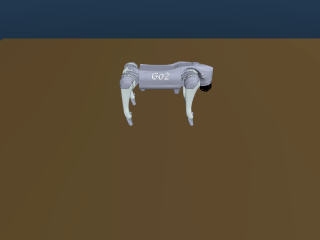

In [16]:
# Render
#camera = rendering.large_overview_camera()
camera = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(camera)
camera.lookat = [-32, 0, 0]
camera.distance = 2
camera.elevation = -30
# image = rendering.render_model(env_model, camera=camera, initial_keyframe="home")
mj_data = mujoco.MjData(env_model)
with mujoco.Renderer(env_model) as renderer:
    mujoco.mj_resetData(env_model, mj_data)
    mj_data.qpos[:3] = env_model.qpos0[:3]
    mj_data.ctrl = init_keyframe.ctrl
    mujoco.mj_forward(env_model, mj_data)
    renderer.update_scene(mj_data, camera=camera)
    image = renderer.render()
rendering.show_image(image)

In [6]:
mj_data.qpos

array([-32.  ,   0.  ,   0.32,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.9 ,  -1.8 ,   0.  ,
         0.9 ,  -1.8 ,   0.  ,   0.9 ,  -1.8 ,   0.  ,   0.9 ,  -1.8 ])

In [11]:
from quadruped_mjx_rl.environments import get_env_factory
from quadruped_mjx_rl.robotic_vision import get_renderer
import functools
from quadruped_mjx_rl.environments.wrappers import wrap_for_training
import jax

make_renderer = functools.partial(get_renderer, vision_config=vision_config)
env_factory = get_env_factory(
    robot_config=robot_config,
    environment_config=environment_config,
    env_model=env_model,
    vision_config=vision_config,
    init_qpos = env_model.qpos0,
    renderer_maker=make_renderer,
)
env = env_factory()

# env = wrap_for_training(
#     env=env,
#     vision=True,
#     num_vision_envs=training_config.num_envs,
# )
# jit_reset = jax.jit(env.reset)
# jit_step = jax.jit(env.step)

/usr/local/lib/python3.11/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


In [12]:
env = wrap_for_training(
    env=env,
    vision=True,
    num_vision_envs=training_config.num_envs,
)
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [13]:
state = jit_reset(jax.random.split(jax.random.PRNGKey(0), training_config.num_envs))

In [13]:
import jax.numpy as jnp
state = jit_step(state, jnp.zeros((training_config.num_envs, env.action_size)))

In [14]:
frontal_view = state.obs["pixels/view_frontal_ego"]
print(frontal_view.shape)
terrain_view = state.obs["pixels/view_terrain"]
print(terrain_view.shape)

(64, 64, 64, 3)
(64, 64, 64, 1)


In [15]:
import mediapy as media

def tile(img, d):
    assert img.shape[0] == d*d
    img = img.reshape((d,d)+img.shape[1:])
    return np.concat(np.concat(img, axis=1), axis=1)  # replace with 2 for multi-camera tensors!

# image = tile(rgb_tensor[:16], 4)
# image.shape
frontal_view_image = tile(frontal_view[:16], 4)
print(frontal_view_image.shape)
terrain_view_image = tile(terrain_view[:16], 4)
print(terrain_view_image.shape)

(256, 256, 3)
(256, 256, 1)


""

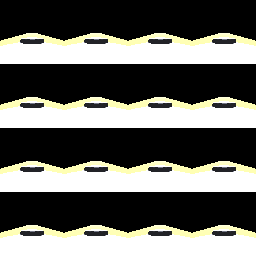

In [16]:
media.show_image(frontal_view_image, width=512)

""

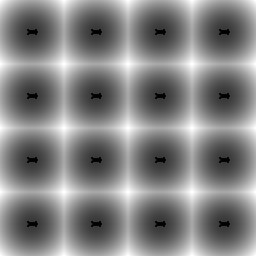

In [16]:
media.show_image(terrain_view_image, width=512)

Starting training with vision...
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually


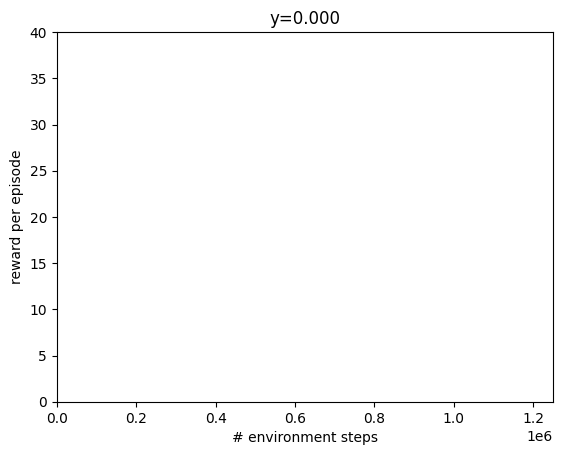

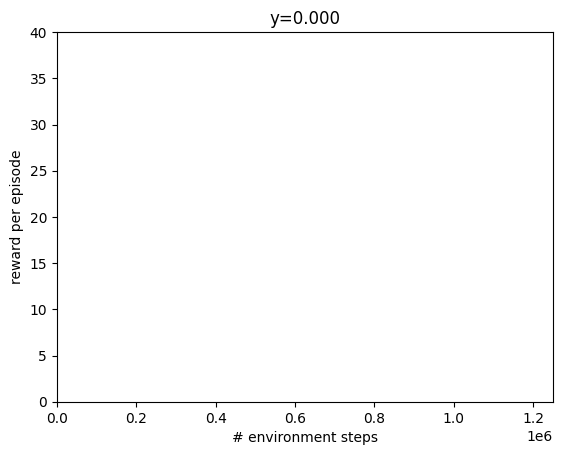

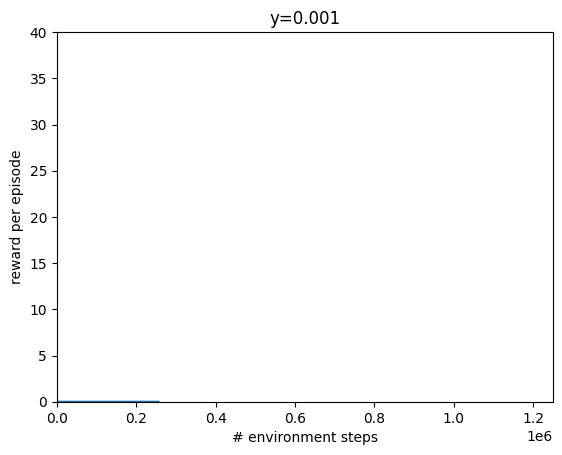

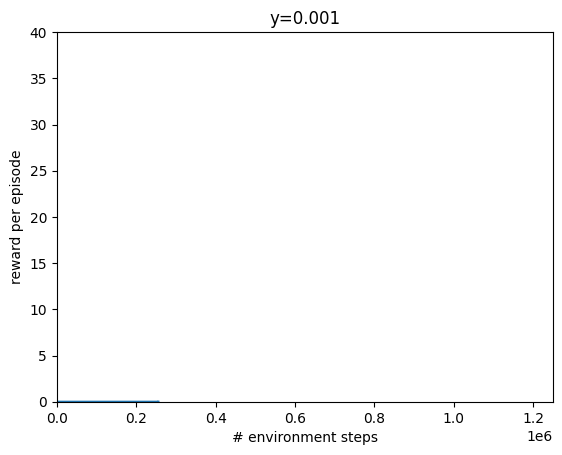

In [ ]:
# @title train
from quadruped_mjx_rl import training

train_fn = training.get_training_fn(
    model_config=model_config, training_config=training_config, vision=True
)
progress_fn, eval_times = training.make_progress_fn(num_timesteps=training_config.num_timesteps)

print("Starting training with vision...")
make_inference_fn, params, metrics = train_fn(
    environment=env,
    # eval_env=env,
    seed=0,
    # randomization_fn=domain_randomize,
    progress_fn=progress_fn,
    # wrap_env=False,
)
print(f"time to jit: {eval_times[1] - eval_times[0]}")
print(f"time to train: {eval_times[-1] - eval_times[1]}")

# Save params
training.save_params(results_path/"trial_run", params)
